In [1]:
import data_loading_code as loader

#### **Load data loader**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        new_row = pd.DataFrame([{
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent)
        }])
        df_ = pd.concat([df_, new_row], ignore_index=True)
    return data

# If this is the primary file that is executed (ie not an import of another file)

# get data, pre-process and split
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']
data = preprocess_pandas(data, columns)                             # pre-process
training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.10,
    random_state=0,
    shuffle=True
)

# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()


#### **Create chatbot**

In [3]:
#Here, a very simple text classifier is created.

class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1/50, Training Loss: 0.6896, Validation Loss: 0.6759, Training Accuracy: 51.22%, Validation Accuracy: 78.00%
Epoch 2/50, Training Loss: 0.6454, Validation Loss: 0.6398, Training Accuracy: 98.22%, Validation Accuracy: 86.00%
Epoch 3/50, Training Loss: 0.5586, Validation Loss: 0.5855, Training Accuracy: 99.44%, Validation Accuracy: 86.00%
Epoch 4/50, Training Loss: 0.4414, Validation Loss: 0.5191, Training Accuracy: 99.89%, Validation Accuracy: 85.00%
Epoch 5/50, Training Loss: 0.3095, Validation Loss: 0.4589, Training Accuracy: 100.00%, Validation Accuracy: 85.00%
Epoch 6/50, Training Loss: 0.2036, Validation Loss: 0.4119, Training Accuracy: 100.00%, Validation Accuracy: 85.00%
Epoch 7/50, Training Loss: 0.1342, Validation Loss: 0.3812, Training Accuracy: 100.00%, Validation Accuracy: 85.00%
Epoch 8/50, Training Loss: 0.0894, Validation Loss: 0.3627, Training Accuracy: 100.00%, Validation Accuracy: 85.00%
Epoch 9/50, Training Loss: 0.0650, Validation Loss: 0.3491, Training Accurac

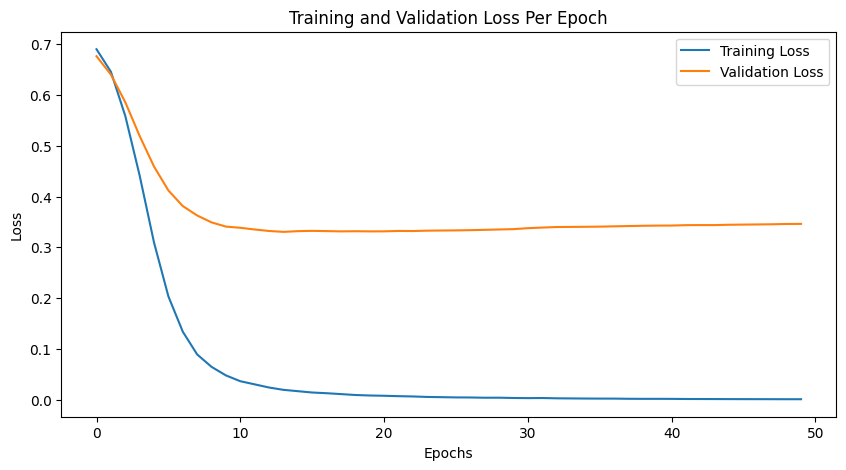

In [13]:
def train_model(model, train_loader, validation_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store loss per epoch
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for texts, labels in train_loader:
            optimizer.zero_grad()   
            outputs = model(texts)  
            loss = criterion(outputs, labels)  
            loss.backward()         
            optimizer.step()        

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct_train / total_train

        model.eval()  
        validation_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for texts, labels in validation_loader:
                outputs = model(texts)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = validation_loss / len(validation_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = 100 * correct_val / total_val

        # Print accuracies for each epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    print('Finished Training')
    return train_losses, val_losses


batch_size = 64
input_dim = vocab_size  # From how many input dimensions we have
hidden_dim = 100        # 100 hidden neurons
output_dim = 2          # Binary classification. Either positive or negative response



train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)



model = TextClassifier(input_dim, hidden_dim, output_dim)


criterion = nn.CrossEntropyLoss()
#Learning rate of 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = train_model(model, train_loader, validation_loader, num_epochs=50)
import matplotlib.pyplot as plt 
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


####

#### **What can be seen is that the validation loss does not improve after 14 epochs, and it starts to increase. This is a sign of overfitting. This means that the final model will be trained with only 14 epochs. The final accuracy is around 87% on the validation set.**

In [15]:
model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = train_model(model, train_loader, validation_loader, num_epochs=14)
torch.save(model.state_dict(), 'text_classifier_model.pth')

Epoch 1/14, Training Loss: 0.6912, Validation Loss: 0.6765, Training Accuracy: 49.67%, Validation Accuracy: 59.00%
Epoch 2/14, Training Loss: 0.6506, Validation Loss: 0.6413, Training Accuracy: 86.89%, Validation Accuracy: 83.00%
Epoch 3/14, Training Loss: 0.5688, Validation Loss: 0.5852, Training Accuracy: 99.22%, Validation Accuracy: 86.00%
Epoch 4/14, Training Loss: 0.4471, Validation Loss: 0.5223, Training Accuracy: 99.67%, Validation Accuracy: 85.00%
Epoch 5/14, Training Loss: 0.3226, Validation Loss: 0.4641, Training Accuracy: 100.00%, Validation Accuracy: 85.00%
Epoch 6/14, Training Loss: 0.2193, Validation Loss: 0.4186, Training Accuracy: 100.00%, Validation Accuracy: 84.00%
Epoch 7/14, Training Loss: 0.1448, Validation Loss: 0.3856, Training Accuracy: 100.00%, Validation Accuracy: 86.00%
Epoch 8/14, Training Loss: 0.0963, Validation Loss: 0.3675, Training Accuracy: 100.00%, Validation Accuracy: 86.00%
Epoch 9/14, Training Loss: 0.0686, Validation Loss: 0.3553, Training Accurac

In [16]:
def prepare_input(text, word_vectorizer):
    vectorized_text = word_vectorizer.transform([text]).todense()  # Vectorize the text
    input_tensor = torch.from_numpy(np.array(vectorized_text)).type(torch.FloatTensor)
    return input_tensor

def generate_response(class_id):
    responses = {
        0: "Negative response.",
        1: "Positive response."
    }
    return responses.get(class_id, "Unknown class response.")

def predict_and_respond(input_text, model, word_vectorizer):
    input_tensor = prepare_input(input_text, word_vectorizer)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)
        return generate_response(predicted_class.item())

def main_loop(model, word_vectorizer):
    model.eval()  # Set the model to evaluation mode
    print("Type 'quit' to exit the program.")
    while True:
        input_text = input("You: ")
        if input_text.lower() == 'quit':
            print("Exiting the program.")
            break
        response = predict_and_respond(input_text, model, word_vectorizer)
        print(f'User: {input_text}')
        print("Bot:", response)

#Load previously trained model
model.load_state_dict(torch.load('text_classifier_model.pth'))

#Create a loop which takes inputs, and generates output
main_loop(model, word_vectorizer)


Type 'quit' to exit the program.
User: I dont like this product
Bot: Negative response.
User: I am modestly impressed by this product
Bot: Negative response.
User: I really like this product
Bot: Positive response.
Exiting the program.
